In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools as it
import pulp
from sklearn.cluster import KMeans
import time
pal = sns.color_palette("hls", 8)

sys.path.append(os.path.join(os.getcwd(), 'code'))
from spatial_generation import Spatial, GroupSpatial
from elections import SNTV,Bloc,STV,Borda,RandomDictator,PRD, PluralityVeto, ChamberlinCourant, Monroe, GreedyCC,RandomDictator2
from tools import cost, best_group_cost, worst_group_cost, representativeness, representativeness_ratio, remove_candidates, borda_matrix
from election_sampling import election_sample, samples

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'votekit'

# Group Representation

In [39]:
# Choose number of voters n
# And the number of candidates m
n = 100
m = 20

# And the number of winners for the election
k = 4

#### 2 Party

In [43]:
# Means for each of the 4 Gaussian distributions
means = [[0, -1.5], [0, 1.5]]
stds = [0.5, 0.5]  # Standard deviations for each Gaussian
two_party_G = [50,50]  # Group Sizes

voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(two_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
candidate_params = {'low': -3, 'high': 3, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

two_party_generator = GroupSpatial(m = m, g = len(two_party_G),
                    voter_dists = [np.random.normal]*len(two_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [61]:
# Generate a profile from random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = two_party_generator.generate([0,100])

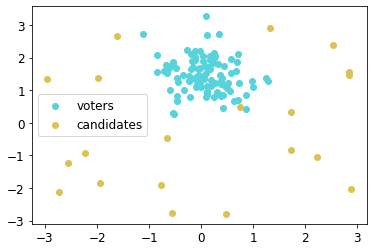

In [62]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

In [8]:
winners = candidate_positions[STV(profile,k),:]
representativeness_ratio(voter_positions, candidate_positions, voter_labels, winners)

1.0

In [33]:
start = time.time()
STV(profile,k)
end = time.time()
print(end - start)

0.02193140983581543


In [34]:
start = time.time()
GreedyCC(profile,k)
end = time.time()
print(end - start)

0.007989168167114258


In [35]:
start = time.time()
ChamberlinCourant(profile,k)
end = time.time()
print(end - start)

2.658217191696167


In [36]:
start = time.time()
Monroe(profile,k)
end = time.time()
print(end - start)

9.50597357749939


### 4 Party

In [73]:
# Means for each of the 4 Gaussian distributions
means = [[-2, 0], [2, 0], [0, 2], [0, -2]]
stds = [0.5, 0.5, 0.5, 0.5]  # Standard deviations for each Gaussian
four_party_G = [25, 25, 25, 25]  # Group Sizes

voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(four_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
candidate_params = {'low': -3, 'high': 3, 'size': 2}

distance = lambda point1, point2: np.linalg.norm(point1 - point2)

four_party_generator = GroupSpatial(m = m, g = len(four_party_G),
                    voter_dists = [np.random.normal]*len(four_party_G), voter_params = voter_params,
                    candidate_dist = np.random.uniform, candidate_params = candidate_params,
                    distance = distance)

In [74]:
# Generate a profile from random candidate and voter positions
profile, candidate_positions, voter_positions, voter_labels = four_party_generator.generate(four_party_G)

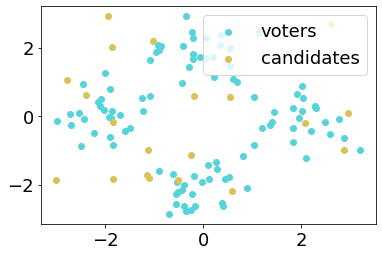

In [75]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = pal[4])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = pal[1])
plt.legend()

### Elections

In [82]:
elections_dict = {SNTV:{}, Bloc:{}, STV:{},
                 Borda:{}, ChamberlinCourant:{}, GreedyCC:{}, Monroe:{},
                  RandomDictator:{'rho': 0.5}, RandomDictator2:{}, PRD:{'rho': 0.5}, PluralityVeto:{}}
elections_list = [SNTV, Bloc, STV, Borda, ChamberlinCourant, GreedyCC, Monroe, 
                  RandomDictator,RandomDictator2, PRD, PluralityVeto]
n_samples = 10

In [83]:
#f = 'data/2party.npz'

start = time.time()
results_list = samples(n_samples, four_party_generator, elections_dict, [four_party_G], k, dim = 2, filename = None)
end = time.time()
print(end - start)

result_dict = results_list[0]
#loaded_data = np.load(f)
#result_dict = {key: loaded_data[key] for key in loaded_data.files}

9.437797546386719


In [106]:
#n_samples = 10
#f = 'data/4party.npz'
#loaded_data = np.load(f)
#result_dict = {key: loaded_data[key] for key in loaded_data.files}

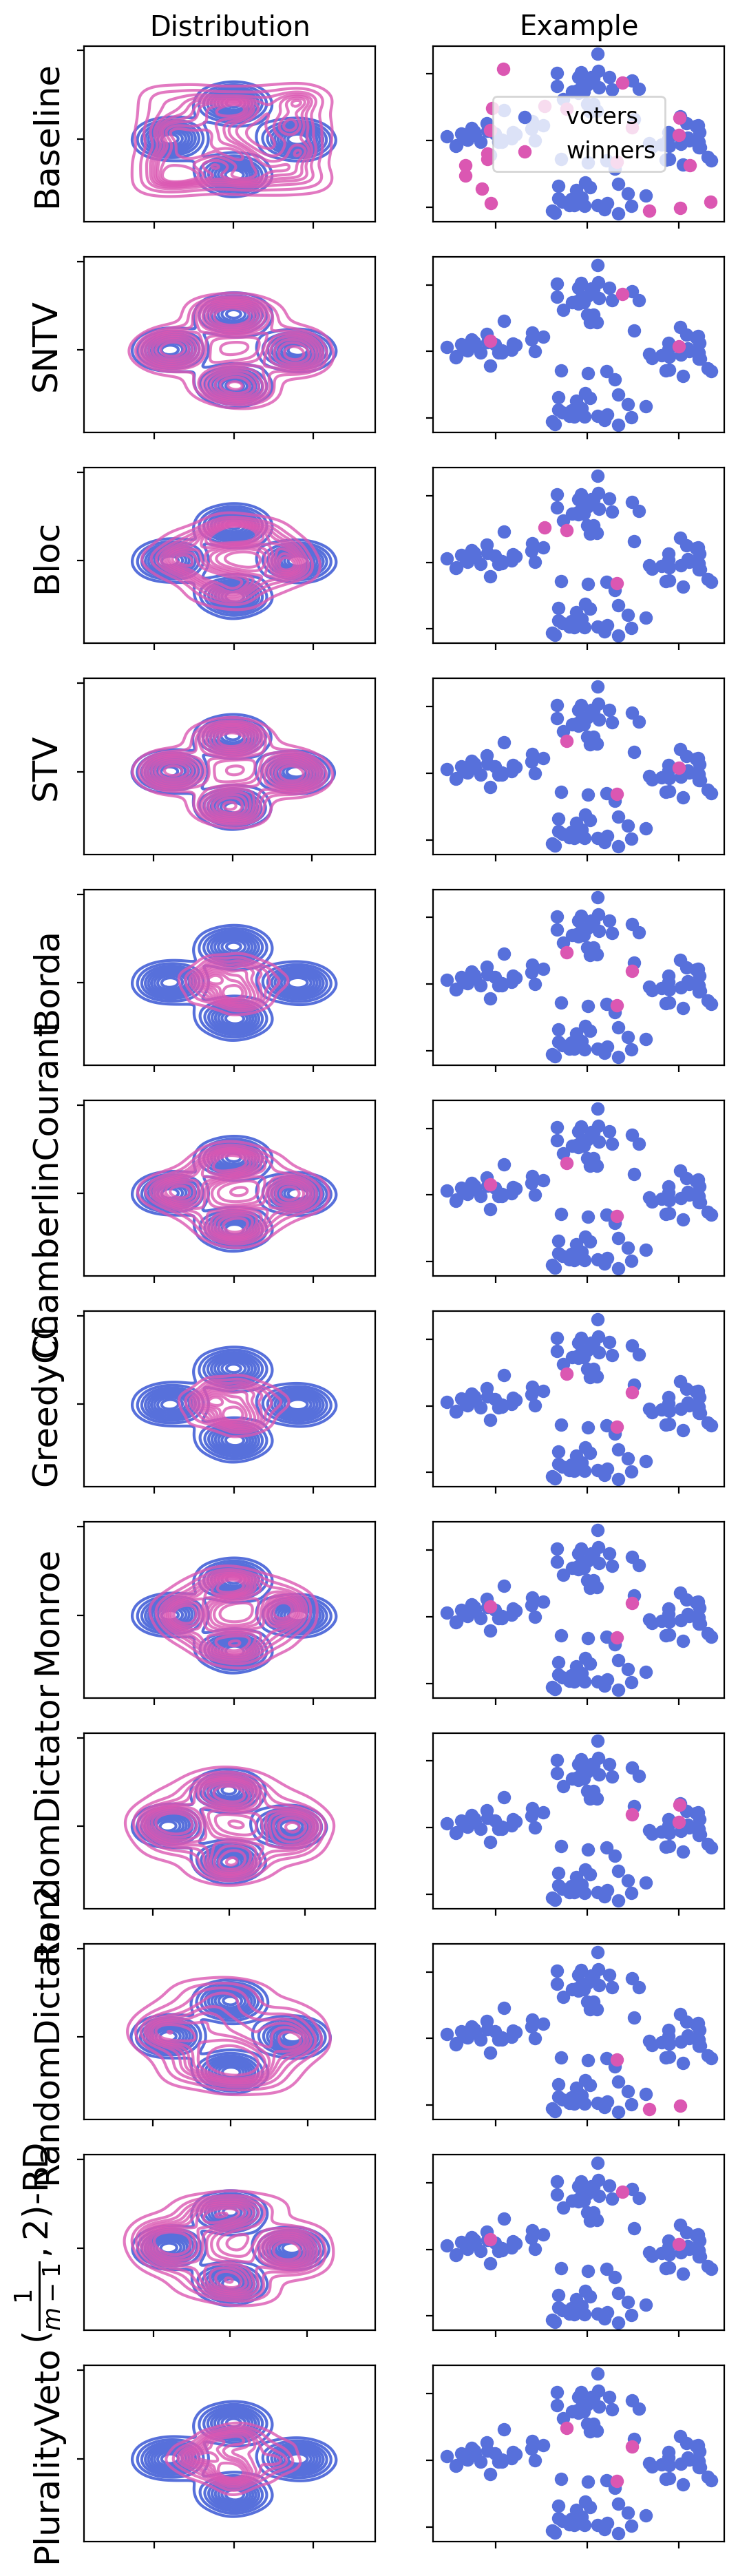

In [38]:
fig, axes = plt.subplots(len(elections_list) + 1, 2, figsize=(6, 24), dpi = 200)
plt.rcParams.update({'font.size': 12})

for i, ax in enumerate(axes.flat):
    #ax.set_xticks([])
    #ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('')

vc = pal[5]
cc = pal[7]

sample_idx = 1
voter_example = result_dict['voters'][sample_idx]
voter_stack = pd.DataFrame(np.vstack(result_dict['voters']), columns = ['x','y'])
#voter_stack = voter_stack.sample(frac=0.1, random_state=42)

# Baseline
candidate_example = result_dict['candidates'][sample_idx]
candidate_stack = pd.DataFrame(np.vstack(result_dict['candidates']), columns = ['x','y'])
#candidate_stack = candidate_stack.sample(frac=0.1, random_state=42)
sns.kdeplot(data=voter_stack, x='x', y='y', color = vc, fill=False,
            thresh=0.1, levels=10, ax = axes[0][0])
sns.kdeplot(data=candidate_stack, x='x', y='y', color = cc, fill=False,
            thresh=0.1, levels=10, alpha = 0.8, ax = axes[0][0])
axes[0][0].set_title('Distribution')
axes[0][0].set_ylabel('Baseline')
axes[0][0].set_xlabel('')

axes[0][1].scatter(voter_example[:,0], voter_example[:,1], label = 'voters', color = vc)
axes[0][1].scatter(candidate_example[:,0], candidate_example[:,1], label = 'winners', color = cc)
axes[0][1].set_title('Example')
axes[0][1].legend()


for i,E in enumerate(elections_list):
    name = E.__name__
    name_label = name
    if name == 'PRD':
        name_label = r'$(\frac{1}{m - 1}, 2)$-RD'
        
    ax_idx = i + 1

    candidate_example = result_dict[name][sample_idx]
    candidate_stack = pd.DataFrame(np.vstack(result_dict[name]), columns = ['x','y'])
    #candidate_stack = candidate_stack.sample(frac=0.1, random_state=42)
    
    sns.kdeplot(data=voter_stack, x='x', y='y', color = vc, fill=False,
                thresh=0.1, levels=10, ax = axes[ax_idx][0])
    sns.kdeplot(data=candidate_stack, x='x', y='y', color = cc, fill=False,
                thresh=0.1, levels=10, alpha = 0.8, ax = axes[ax_idx][0])
    
    axes[ax_idx][0].set_ylabel(name_label)
    axes[ax_idx][0].set_xlabel('')
    
    axes[ax_idx][1].scatter(voter_example[:,0], voter_example[:,1], label = 'voters', color = vc)
    axes[ax_idx][1].scatter(candidate_example[:,0], candidate_example[:,1], label = 'winners', color = cc)



#plt.savefig('figures/2party.png', bbox_inches='tight')

### Representativeness

In [101]:
avg_represent = {e.__name__:np.zeros(n_samples) for e in elections_list}
avg_represent_ratio = {e.__name__:np.zeros(n_samples) for e in elections_list}

for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        represent = representativeness(voter_positions, candidate_positions, labels, winners)

        represent_ratio = representativeness_ratio(voter_positions, candidate_positions, labels, winners)
        avg_represent[name][i] = represent
        avg_represent_ratio[name][i] = represent_ratio

In [105]:
25/100 * 3

0.75

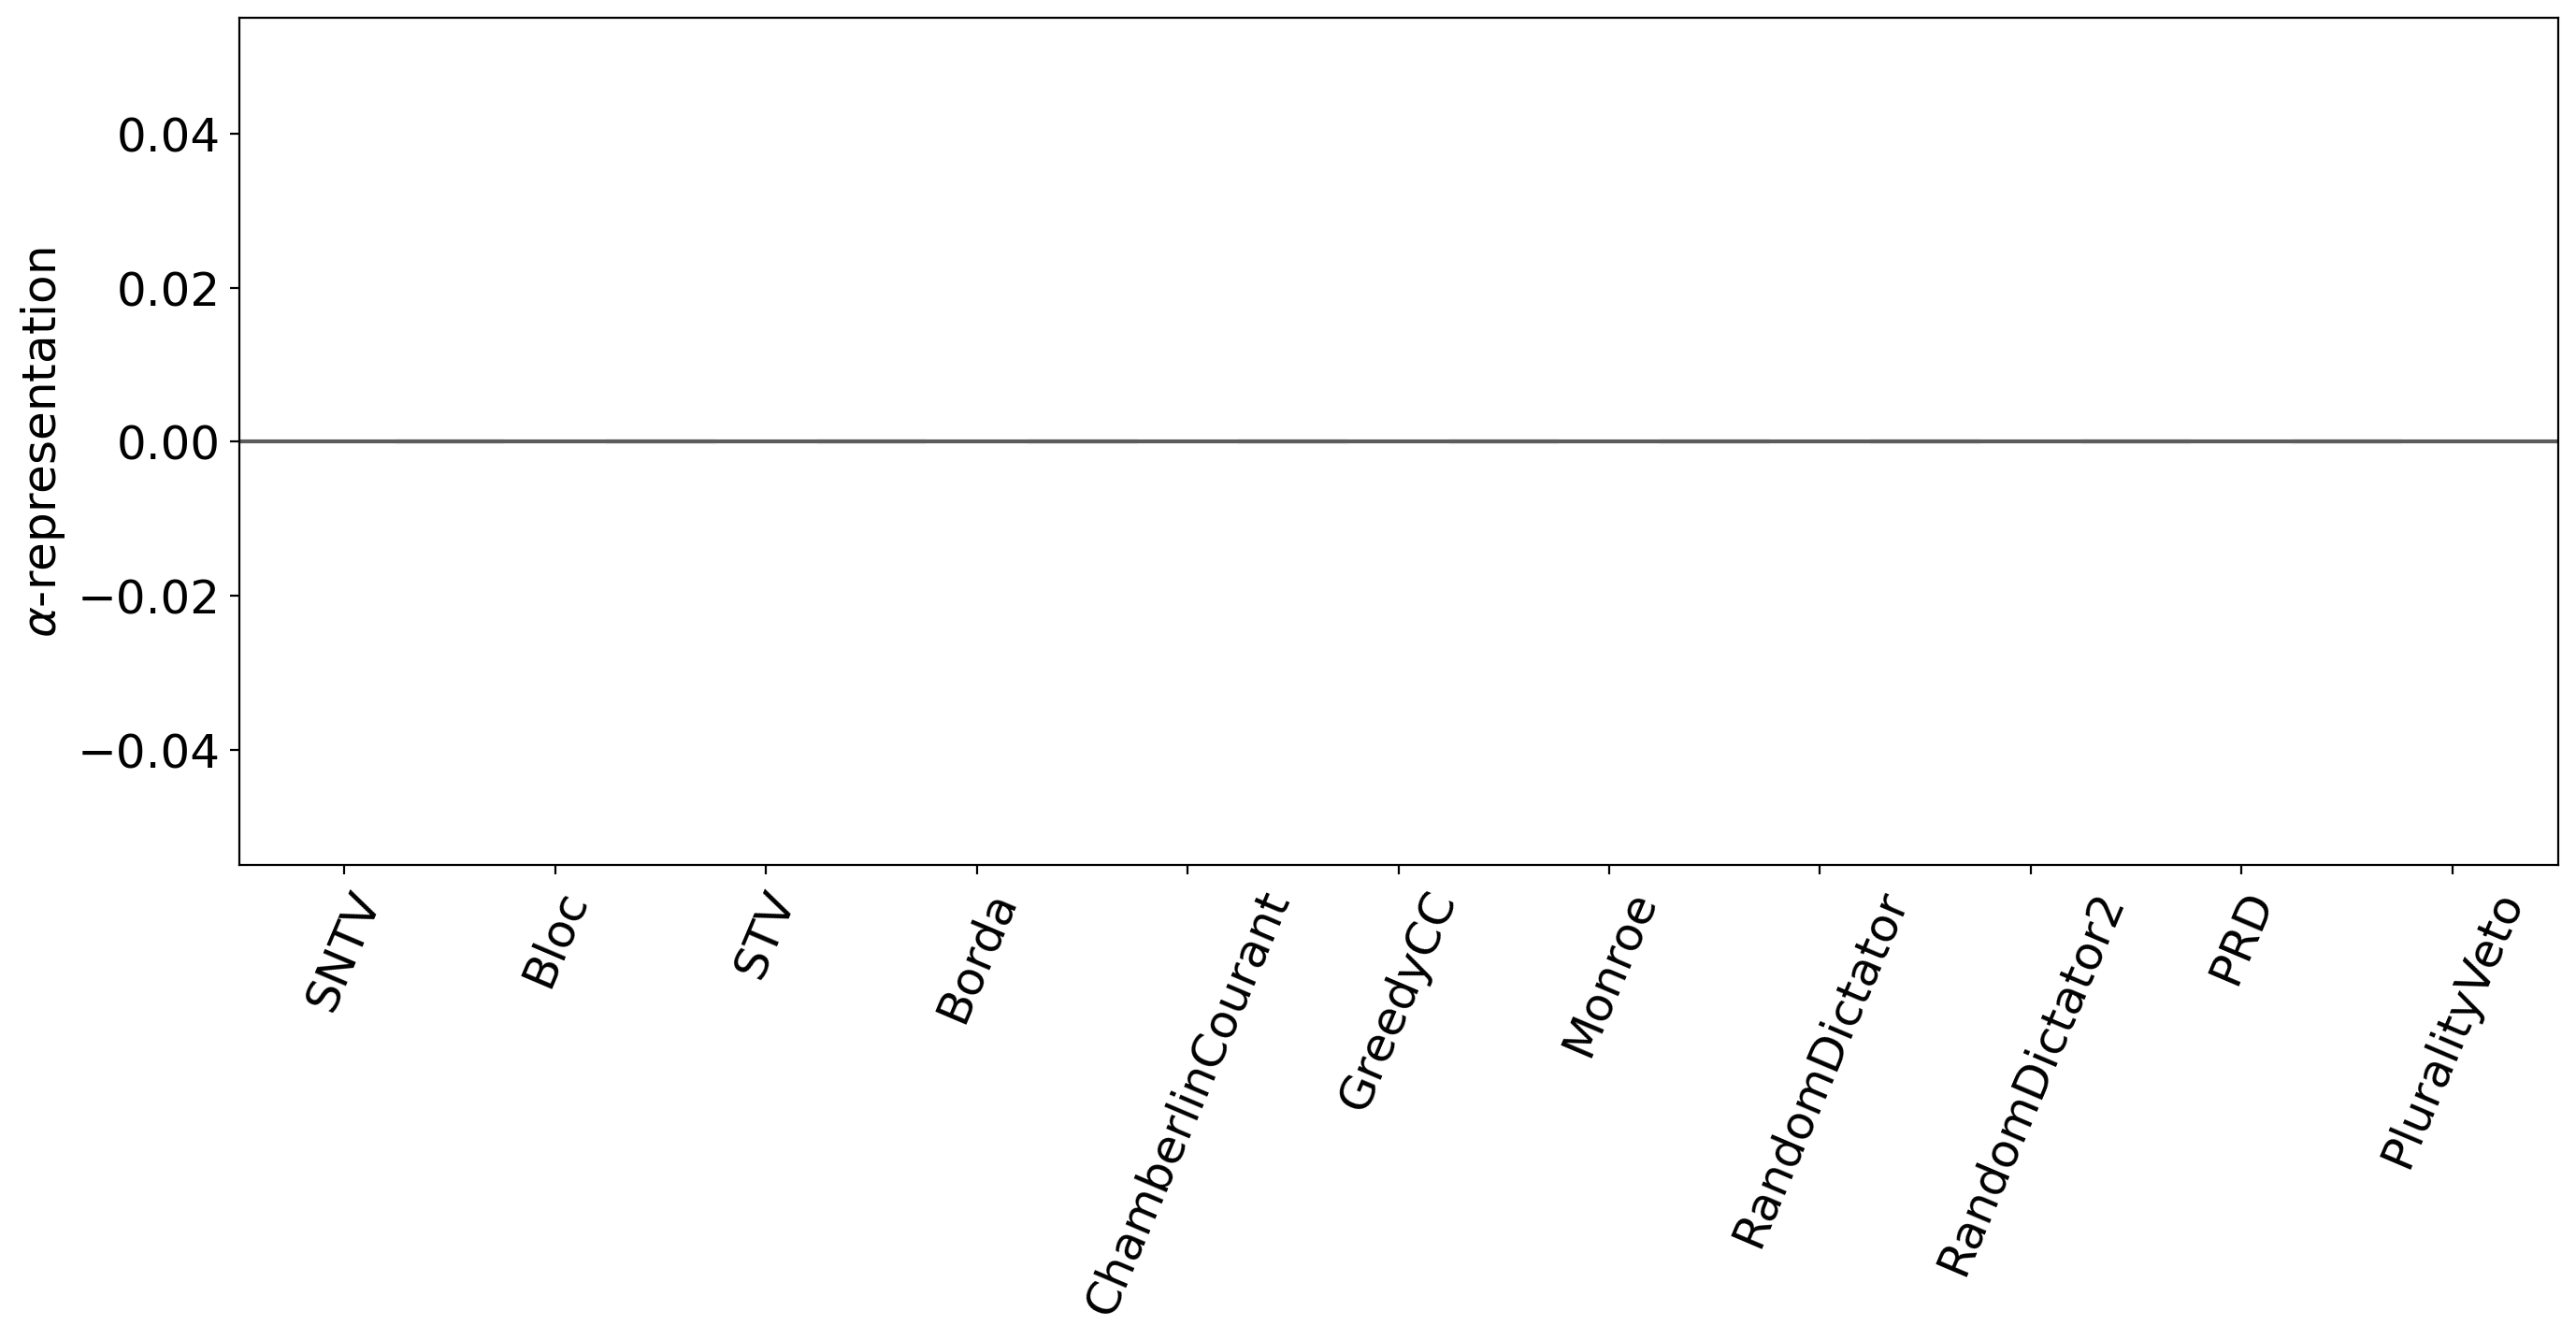

In [102]:
# Combine the arrays into a list
represent_data = [values for values in avg_represent.values()]
represent_labels = [name for name in avg_represent.keys()]

plt.rcParams.update({'font.size': 18})
# Create a violin plot
plt.figure(figsize=(16, 6), dpi = 200)
ax = sns.violinplot(data=represent_data, palette = pal[2:], alpha = 1, width = 1.5)
for violin in ax.collections:
    violin.set_alpha(1)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels, rotation=67)
plt.ylabel(r'$\alpha$-representation')
#plt.savefig('figures/2party_representation.png', bbox_inches='tight')
plt.show()

In [94]:
avg_represent1 = {e.__name__:np.zeros(n_samples) for e in elections_list}
avg_represent_ratio1 = {e.__name__:np.zeros(n_samples) for e in elections_list}

for i in range(n_samples):
    voter_positions = result_dict['voters'][i]
    candidate_positions = result_dict['candidates'][i]
    labels = result_dict['labels'][i]
    labels = np.zeros(len(labels))
    
    for j,E in enumerate(elections_list):
        name = E.__name__
        winners = result_dict[name][i]
        represent = representativeness(voter_positions, candidate_positions, labels, winners)
        represent_ratio = representativeness_ratio(voter_positions, candidate_positions, labels, winners)
        avg_represent1[name][i] = represent
        avg_represent_ratio1[name][i] = represent_ratio

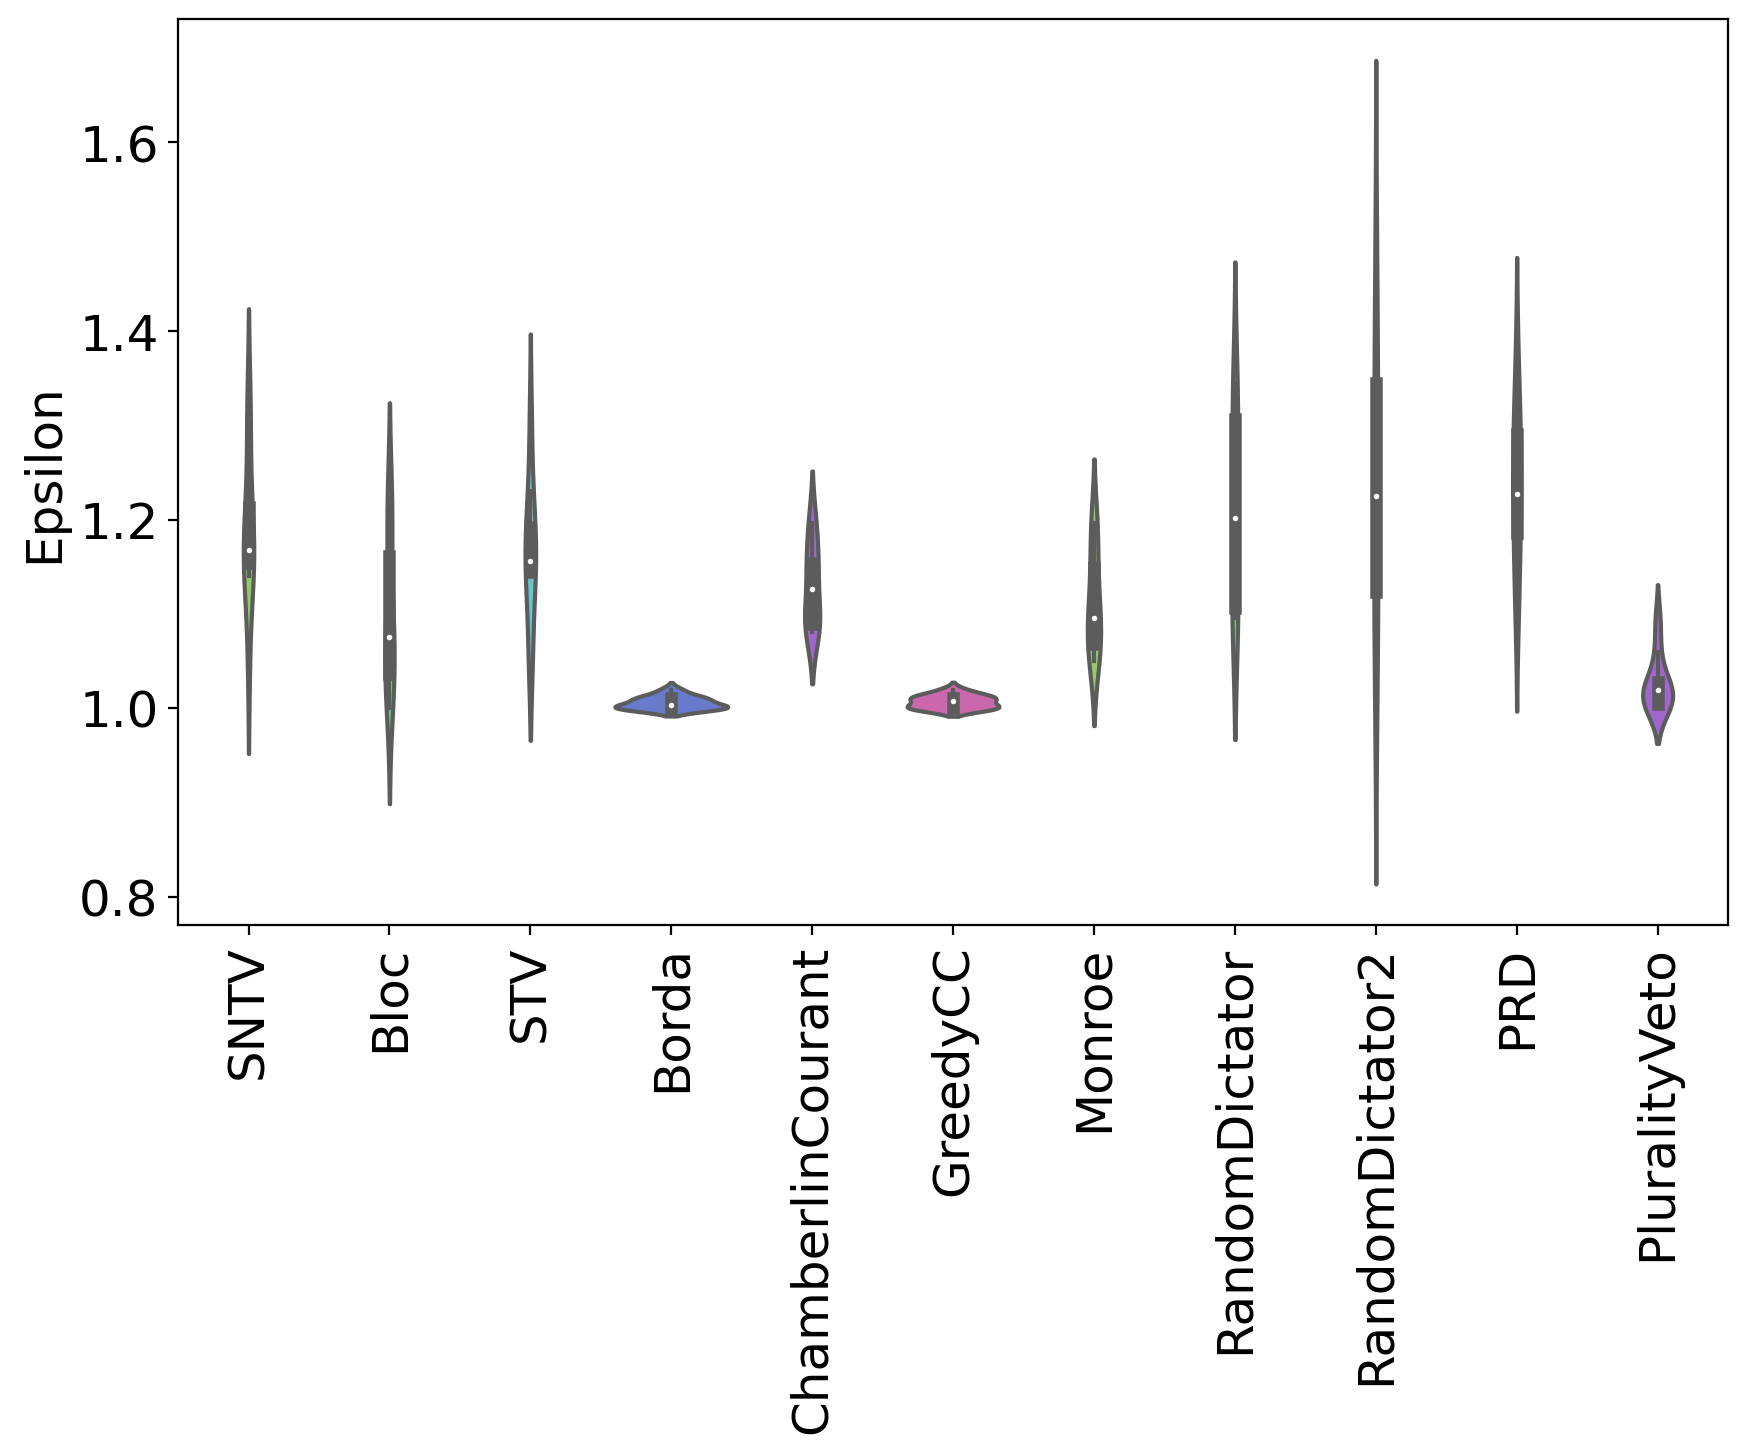

In [95]:
# Combine the arrays into a list
represent_data = [values for values in avg_represent_ratio1.values()]
represent_labels = [name for name in avg_represent_ratio1.keys()]

plt.rcParams.update({'font.size': 18})
# Create a violin plot
plt.figure(figsize=(10, 6), dpi = 200)
ax = sns.violinplot(data=represent_data, palette = pal[2:], alpha = 1)
for violin in ax.collections:
    violin.set_alpha(1)
plt.xticks(ticks=np.arange(len(elections_list)), labels=represent_labels, rotation=90)
plt.ylabel('Epsilon')
#plt.savefig('figures/2party_representation1.png', bbox_inches='tight')
plt.show()

In [96]:
represent_data

[array([1.15667346, 1.29851072, 1.14058877, 1.22487412, 1.05146339,
        1.17302409, 1.32394707, 1.16329348, 1.15294893, 1.17817747]),
 array([1.07460431, 1.22244066, 1.18064913, 1.0301662 , 1.0306729 ,
        1.        , 1.21493873, 1.07659847, 1.10345714, 1.05066982]),
 array([1.14341805, 1.30419462, 1.05917138, 1.14829255, 1.05840744,
        1.19606305, 1.22989356, 1.16329348, 1.14557677, 1.17817747]),
 array([1.        , 1.01888712, 1.01055774, 1.00926286, 1.        ,
        1.00144788, 1.        , 1.00519329, 1.        , 1.01140346]),
 array([1.08714764, 1.10660084, 1.08118374, 1.1930572 , 1.09642795,
        1.19606305, 1.15052087, 1.0873423 , 1.14557677, 1.15505221]),
 array([1.        , 1.01888712, 1.01055774, 1.00926286, 1.        ,
        1.01359255, 1.        , 1.00519329, 1.        , 1.01140346]),
 array([1.08714764, 1.13174624, 1.05917138, 1.1930572 , 1.09642795,
        1.19606305, 1.06151684, 1.095335  , 1.04961359, 1.15505221]),
 array([1.10123634, 1.28337201, 1.

### Changing Group Membership

In [ ]:
used_samples = 100
max_clusters = 20
avg_cluster_represent = {e.__name__:np.zeros((m, used_samples)) for e in elections_list}

for t in range(1,max_clusters):
    print(t)
    for i in range(used_samples):
        voter_positions = result_dict['voters'][i]
        # partition voters to groups
        kmeans = KMeans(n_clusters=t, random_state=0, n_init="auto").fit(voter_positions)
        labels = kmeans.labels_
        groups = [[j for j in range(len(labels)) if labels[j] == i] for i in np.unique(labels)]
        candidate_positions = result_dict['candidates'][i]
        
        for j,E in enumerate(elections_list):
            name = E.__name__
            winners = result_dict[name][i]
            represent = representativeness(voter_positions, candidate_positions, groups, winners)
            avg_cluster_represent[name][t-1,i] = represent

In [ ]:
fig,ax = plt.subplots(dpi = 200)
up_to = 20
for i,E in enumerate(elections_list):
    cluster_data = avg_cluster_represent[E.__name__]
    means = np.mean(cluster_data, axis=1)
    means = means[:up_to]
    std_devs = np.std(cluster_data, axis=1)
    std_devs = std_devs[:up_to]
    
    ax.plot(means, label=E.__name__, color=pal[2+i], linewidth = 3)
    ax.fill_between(range(up_to), means - std_devs, means + std_devs, color=pal[2+i], alpha=0.05)

plt.xlabel('Number of Clusters')
plt.ylabel('Epsilon')
plt.legend()
plt.savefig('figures/2party_cluster.png', bbox_inches='tight')
plt.show()